In [1]:
import numpy as np
import pandas as pd
import random
%matplotlib inline
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from wordcloud import WordCloud,STOPWORDS
import re
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer

In [2]:
embedding_dim = 100 # chiều của vécto embedding từ
vocab_size = 1500 #số lượng vocab từ lấy ra từ thư viện embedding
maxlen = 70 # chiều dài tối đa của 1 từ sau khi làm tròn

tagset_size = 1 # số lượng nhãn
batch_size=512
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [3]:
def set_seed(seed_value=2022):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
set_seed()

# import dataset

In [4]:
train_df = pd.read_csv('./train.csv')
train_df = train_df[:10000]
test_df = pd.read_csv('./test.csv')
test_df = test_df[:2000]

In [5]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


# Analysis

In [6]:
labels = collections.Counter(train_df['target']).keys()
amounts = collections.Counter(train_df['target']).values()
labels, amounts

(dict_keys([0, 1]), dict_values([9363, 637]))

(637, 3) (9363, 3)
--------------------------


<AxesSubplot:xlabel='target', ylabel='count'>

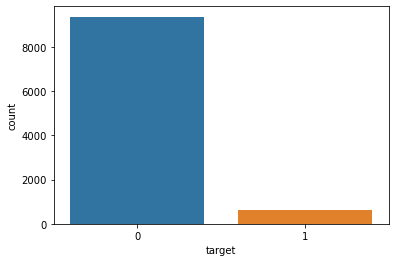

In [7]:
insincere_data_train = train_df[train_df.target == 1]
sincere_data_train = train_df[train_df.target == 0]
print(insincere_data_train.shape, sincere_data_train.shape)
print("--------------------------")

sns.countplot(x='target', data=train_df)

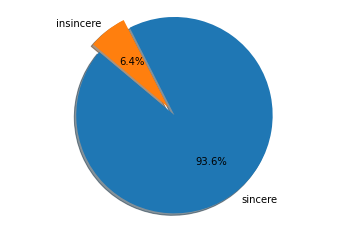

In [8]:
sincere_percent= (len(train_df.question_text[train_df['target'] == 0]) /  len(train_df['question_text']) * 100)
insincere_percent= (len(train_df.question_text[train_df['target'] == 1]) / len(train_df['question_text']) * 100)
__labels = 'sincere', 'insincere'
sizes = [sincere_percent, insincere_percent]
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=__labels,autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

<AxesSubplot:>

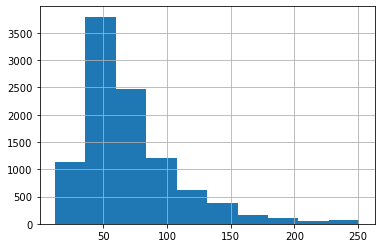

In [9]:
train_df['question_text'].str.len().hist()


<AxesSubplot:>

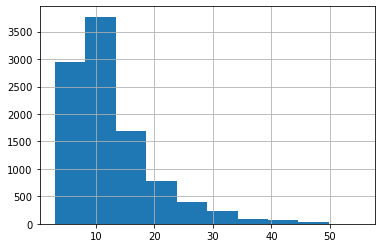

In [10]:
train_df['question_text'].str.split().map(lambda x: len(x)).hist()

[Text(0.5, 1.0, 'Words have the most frequency in train dataset')]

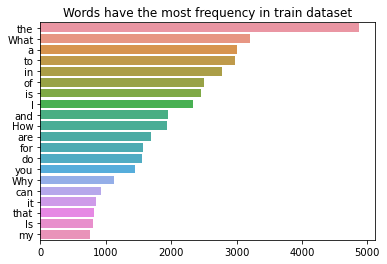

In [11]:
new_corpus = []
quest = train_df['question_text'].str.split()
quest = quest.values.tolist()
new_corpus = [word for q in quest for word in q]
counter = collections.Counter(new_corpus)
most = counter.most_common()

x,y= [],[]
for word,count in most[:20]:
    x.append(word)
    y.append(count)

sns.barplot(x=y,y=x).set(title='Words have the most frequency in train dataset')

[Text(0.5, 1.0, 'Words have the most frequency in test dataset')]

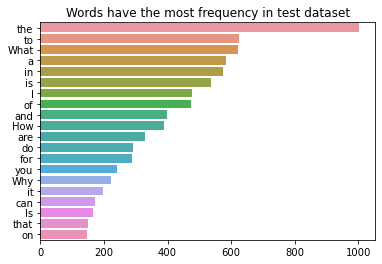

In [12]:
new_corpus = []
quest = test_df['question_text'].str.split()
quest = quest.values.tolist()
new_corpus = [word for q in quest for word in q]
counter = collections.Counter(new_corpus)
most = counter.most_common()

x,y= [],[]
for word,count in most[:20]:
    x.append(word)
    y.append(count)

sns.barplot(x=y,y=x).set(title='Words have the most frequency in test dataset')

In [13]:
def bigrams_data(data):
    bigrams = []
    for question in data:
        question = [w for w in question.lower().split() if w not in STOPWORDS] # skip từ stopword
        if not question: 
            continue # skip question do nltk.bigrmas
        bi = [b for b in nltk.bigrams(question)]
        bi = [' '.join(w) for w in bi]
        bigrams.extend(bi)
    return bigrams

def draw_plt(data, title, bar_color, numberOfWordsInTop):
    top_words = collections.Counter(data).most_common(numberOfWordsInTop) # 25 từ xuất hiện nhiều nhất

    df_top = pd.DataFrame(top_words, columns=['word', 'count']).sort_values('count')

    plt.barh(df_top['word'].values, df_top['count'].values, orientation='horizontal', color=bar_color)
    plt.title(f'Top words in {title}')

bigrams_sincere = bigrams_data(train_df[train_df['target']==0]['question_text'])
bigrams_insincere = bigrams_data(train_df[train_df['target']==1]['question_text'])

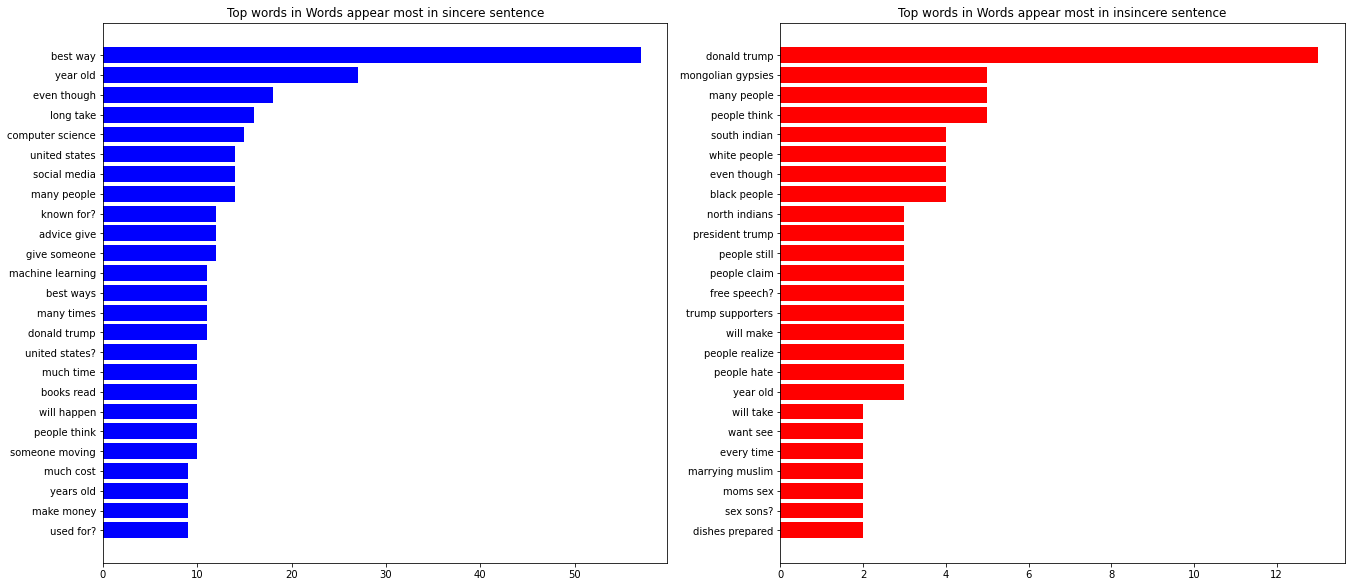

In [14]:
plt.subplot(1, 2, 1)
draw_plt(bigrams_sincere, 'Words appear most in sincere sentence', 'blue',25)


plt.subplot(1, 2, 2)
draw_plt(bigrams_insincere, 'Words appear most in insincere sentence', 'red',25)

plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

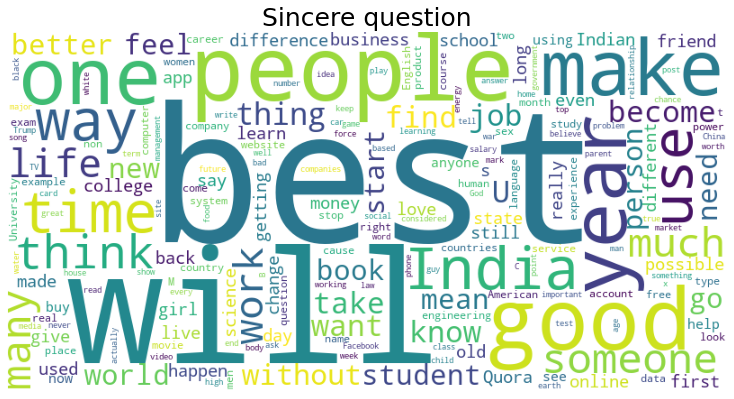

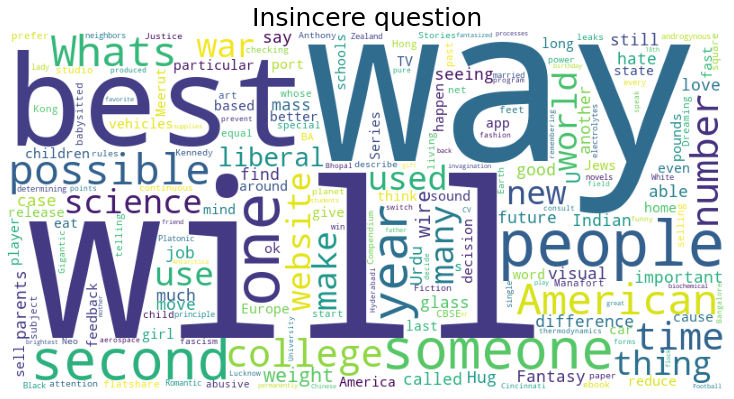

In [15]:
def cloud(docs, title):
    wordcloud = WordCloud(width=800, height=400, collocations=False, background_color="white").generate(" ".join(docs))
    fig = plt.figure(figsize=(10,7), facecolor='w')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=25,color='k')
    plt.tight_layout(pad=0)
    plt.show()
cloud(train_df[train_df['target']==0]['question_text'], "Sincere question")
cloud(test_df['question_text'][train_df['target']==1], "Insincere question")

# Preprocessing

In [16]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2",
                 "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '”': '"', '“': '"', "£": "e",
                 '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta',
                 '∅': '', '³': '3', 'π': 'pi', '\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
for p in puncts:
    punct_mapping[p] = ' %s ' % p

p = re.compile('(\[ math \]).+(\[ / math \])')
p_space = re.compile(r'[^\x20-\x7e]')

#
def remove_stopwords(text):
    text = [word for word in text.split() if word not in STOPWORDS]
    text = ' '.join(text)
    return text

def clean_text(text):
    # clean latex maths
    text = p.sub(' [ math ] ', text)
    # clean invisible chars
    text = p_space.sub(r'', text)
    # clean punctuations
    for punct in punct_mapping:
        if punct in text:
            text = text.replace(punct, punct_mapping[punct])
    #Remove stop word
#     text = remove_stopwords(text)
    return text

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

mispell_dict = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
                "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
                "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would",
                "i'd've": "i would have", "i'll": "i will", "i'll've": "I will have", "i'm": "i am",
                "i've": "I have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
                "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
                "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
                "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                "there'd've": "there would have", "there's": "there is", "here's": "here is",
                "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                "they'll've": "they will have", "they're": "they are", "they've": "they have",
                "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
                "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
                "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color',
                'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling',
                'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize',
                'youtu ': 'youtube ', 'qoura': 'quora', 'sallary': 'salary', 'whta': 'what',
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doi': 'do I',
                'thebest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation',
                'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis',
                'etherium': 'ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017',
                '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess',
                "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization',
                'demonitization': 'demonetization', 'demonetisation': 'demonetization'}
#Removing Contractions/ chữa các từ chính tả
def replace_typical_misspell(text):
    tokens = []
    for token in text.split():
        # replace contractions & correct misspells
        token = mispell_dict.get(token.lower(), token)
        tokens.append(token)
    text = ' '.join(tokens)
    return text
    
#Remove contraction / Xoá các từ contraction
contraction_map = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    
    text = ' '.join([contraction_map[t] if t in contraction_map else t for t in text.split(" ")])
    return text
    

In [17]:
from sklearn.preprocessing import StandardScaler
tqdm.pandas()
# Thêm một số trường dữ liệu
def add_features(df):
    
    df['question_text'] = df['question_text'].progress_apply(lambda x:str(x))
    df['total_length'] = df['question_text'].progress_apply(len)
    df['capitals'] = df['question_text'].progress_apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.progress_apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df['num_words'] = df.question_text.str.count('\S+')
    df['num_unique_words'] = df['question_text'].progress_apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']  

    return df

def load_and_prec():
    print("Train shape : ",train_df.shape)
    print("Test shape : ",test_df.shape)
    
    
    # Lower
    train_df["question_text"] = train_df["question_text"].apply(lambda x: x.lower())
    test_df["question_text"] = test_df["question_text"].apply(lambda x: x.lower())

    # Clean the text
    train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: clean_text(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_text(x))
    # Clean numbers
    train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: clean_numbers(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_numbers(x))
    
    # Clean speelings
    train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: replace_typical_misspell(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: replace_typical_misspell(x))
    
    # Fill up the missing values
    train_X = train_df["question_text"].fillna("_##_").values
    test_X = test_df["question_text"].fillna("_##_").values
    
    
    ###################### Add Features ###############################
    train = add_features(train_df)
    test = add_features(test_df)
    
    features = train[['caps_vs_length', 'words_vs_unique']].fillna(0)
    test_features = test[['caps_vs_length', 'words_vs_unique']].fillna(0)

    ss = StandardScaler()
    ss.fit(np.vstack((features, test_features)))
    features = ss.transform(features)
    test_features = ss.transform(test_features)
    ###########################################################################

    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    test_X = pad_sequences(test_X, maxlen=maxlen)

    ## Get the target values
    train_y = train_df['target'].values
    

    #shuffling the data
    np.random.seed(2022)
    trn_idx = np.random.permutation(len(train_X))

    train_X = train_X[trn_idx]
    train_y = train_y[trn_idx]
    features = features[trn_idx]
    
    return train_X, test_X, train_y, features, test_features, tokenizer.word_index

In [18]:
x_train, x_test, y_train,features, test_features, word_index = load_and_prec() 

Train shape :  (10000, 3)
Test shape :  (2000, 2)


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
x_train

array([[   0,    0,    0, ...,   25,   57,    6],
       [   0,    0,    0, ...,    4,   97,    4],
       [   0,    0,    0, ...,  382,  187,   39],
       ...,
       [   0,    0,    0, ...,   27,  602,   74],
       [   0,    0,    0, ...,   14,   26, 1337],
       [   0,    0,    0, ...,    5,  260,   47]], dtype=int32)

# run a quick sentiment analysis using TextBlob

In [20]:
# pip install textblob

In [21]:
from textblob import TextBlob

In [22]:
train_df.head()

,qid,question_text,target,total_length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique
0,00002165364db923c7e6,how did quebec nationalists see their province...,0,73,0,0.0,14,14,1.000000
1,000032939017120e6e44,"do you have an adopted dog , how would you enc...",0,83,0,0.0,18,17,0.944444
2,0000412ca6e4628ce2cf,why does velocity affect time ? does velocity ...,0,69,0,0.0,12,8,0.666667
3,000042bf85aa498cd78e,how did otto von guericke used the magdeburg h...,0,58,0,0.0,10,10,1.000000
4,0000455dfa3e01eae3af,can i convert montra helicon d to a mountain b...,0,78,0,0.0,16,16,1.000000


In [23]:
train_df['polarity'] = train_df['question_text'].apply(lambda x:TextBlob(x).sentiment[0])

In [24]:
train_df['subjectivity'] = train_df['question_text'].apply(lambda x:TextBlob(x).sentiment[1])

In [25]:
train_df.describe()

,target,total_length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique,polarity,subjectivity
count,10000.00000,10000.00000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.06370,72.37460,0.0001,0.000002,14.691900,13.623200,0.953512,0.104984,0.277988
std,0.24423,39.39911,0.0100,0.000189,8.130374,6.469576,0.070202,0.293581,0.305944
min,0.00000,13.00000,0.0000,0.000000,3.000000,3.000000,0.425532,-1.000000,0.000000
25%,0.00000,46.00000,0.0000,0.000000,9.000000,9.000000,0.916667,0.000000,0.000000
50%,0.00000,62.00000,0.0000,0.000000,12.000000,12.000000,1.000000,0.000000,0.200000
75%,0.00000,87.00000,0.0000,0.000000,18.000000,16.000000,1.000000,0.200000,0.500000
max,1.00000,288.00000,1.0000,0.018868,83.000000,48.000000,1.000000,1.000000,1.000000


# Use Glove and run model

In [26]:
def load_glove(word_index):
    EMBEDDING_FILE = './glove.6B.100d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(vocab_size, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in tqdm(word_index.items()):
        if i >= vocab_size: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 
    


In [27]:
set_seed()
embedding_matrix = load_glove(word_index)

/Users/quanghung/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


  0%|          | 0/15044 [00:00<?, ?it/s]

In [28]:
np.shape(embedding_matrix)

(1500, 100)

In [29]:
class MyDataset(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        data, target = self.dataset[index]

        return data, target, index
    def __len__(self):
        return len(self.dataset)

In [30]:
splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=2022).split(x_train, y_train))

In [31]:
hidden_size = 64

class BiLSTM(nn.Module):
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, tagset_size)
    def forward(self, x):
        #rint(x.size())*
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))*
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [32]:
# matrix for the out-of-fold predictions
train_preds = np.zeros((len(x_train)))
# matrix for the predictions on the test set
test_preds = np.zeros((len(test_df)))

# always call this before training for deterministic results
# seed_everything()

x_test_cuda = torch.tensor(x_test, dtype=torch.long).to(device)
test = torch.utils.data.TensorDataset(x_test_cuda)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

avg_losses_f = []
avg_val_losses_f = []
train_loss = []
valid_loss = []

# Tracking best validation accuracy
best_accuracy = 0

In [33]:
base_lr, max_lr = 0.001, 0.003
def optimizers(model):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=max_lr)
    return optimizer

In [34]:
# define binary cross entropy loss
# note that the model returns logit to take advantage of the log-sum-exp trick 
# for numerical stability in the loss
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='sum')

In [35]:
def create_data_loader(x_train,y_train,train_idx, valid_idx,batch_size):
    # split data in train / validation according to the KFold indeces
    # also, convert them to a torch tensor and store them on the GPU (done with .cuda())
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    
    x_train_fold = torch.tensor(x_train[train_idx.astype(int)], dtype=torch.long).to(device)
    y_train_fold = torch.tensor(y_train[train_idx.astype(int), np.newaxis], dtype=torch.float32).to(device)
    
    x_val_fold = torch.tensor(x_train[valid_idx.astype(int)], dtype=torch.long).to(device)
    y_val_fold = torch.tensor(y_train[valid_idx.astype(int), np.newaxis], dtype=torch.float32).to(device)
    
    #############################################################################################
    train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)
    
    train = MyDataset(train)
    valid = MyDataset(valid)
    
    ##No need to shuffle the data again here. Shuffling happens when splitting for kfolds.
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    return train_loader,valid_loader

In [36]:
#eval model
def evaluate(model, valid_loader):
    
    # set evaluation mode of the model. This disabled operations which are only applied during training like dropout
    model.eval()
    # predict all the samples in y_val_fold batch per batch
    valid_preds_fold = np.zeros(len(valid_idx))
    avg_val_loss = 0
    val_accuracy = []
    
    for i, (x_batch, y_batch, index) in enumerate(valid_loader):
        
        with torch.no_grad():
            y_pred = model(x_batch).detach()
        
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        valid_preds_fold[i * batch_size:(i+1) * batch_size] = torch.special.expit(y_pred).cpu().numpy()[:, 0]
        if i==0 and epoch == 0:
            valid_loss.append(loss_fn(y_pred, y_batch))
        train_preds[valid_idx] = valid_preds_fold
        # Get the predictions
        preds = torch.argmax(y_pred, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == y_batch).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
    accuracy = sum(val_accuracy)/len(val_accuracy)
    
    print('val_accuracy = {:.4f} '.format(accuracy))
    return valid_preds_fold, avg_val_loss
#predicts model
def predict(model, test_loader):
    # predict all samples in the test set batch per batch
    test_preds_fold = np.zeros((len(test_df)))
    for i, (x_batch,) in enumerate(test_loader):
        
        y_pred = model(x_batch).detach()
        test_preds_fold[i * batch_size:(i+1) * batch_size] = torch.special.expit(y_pred).cpu().numpy()[:, 0]
    return test_preds_fold

In [37]:
n_epochs = 5
set_seed()
for i, (train_idx, valid_idx) in enumerate(splits):
    train_loader,valid_loader = create_data_loader(x_train,y_train,train_idx, valid_idx,batch_size)
    model = BiLSTM()

    # make sure everything in the model is running on the GPU
    model.to(device)
    
    optimizer = optimizers(model)
    print(f'Fold {i + 1}')
    for epoch in range(n_epochs):
        # =======================================
        #               Training
        # =======================================
        start_time = time.time()
        # set train mode of the model. This enables operations which are only applied during training like dropout
        
        model.train()
        avg_loss = 0.  
        for i, (x_batch, y_batch, index) in enumerate(train_loader):
            
            # Forward pass: compute predicted y by passing x to the model.           
            y_pred = model(x_batch)
            
            # Compute and print loss.
            loss = loss_fn(y_pred, y_batch)

            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the Tensors it will update (which are the learnable weights
            # of the model)
            optimizer.zero_grad()
             # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()
            avg_loss += loss.item()
            if(epoch==0 and i==0):
                train_loss.append(loss.item())
        
        # Calculate the average loss over the entire training data        
        avg_loss = avg_loss / len(train_loader)    
        
        
        # =======================================
        #               Evaluation
        # =======================================
        if valid_loader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            valid_preds_fold, avg_val_loss = evaluate(model, valid_loader)
            elapsed_time = time.time() - start_time 
            print('Epoch {}/{} \t avg_loss={:.4f} \t avg_val_loss={:.4f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, elapsed_time))
        
        
    avg_losses_f.append(avg_loss)
    avg_val_losses_f.append(avg_val_loss) 
    #predics test_data_loader
    test_preds_fold = predict(model, test_loader)
    test_preds += test_preds_fold / len(splits)
    
    ##predics train_data_loader
    train_preds[valid_idx] = valid_preds_fold

print('All \t loss={:.4f} \t val_loss={:.4f} \t '.format(np.average(avg_losses_f),np.average(avg_val_losses_f)))

Fold 1
val_accuracy = 93.6372 
Epoch 1/5 	 avg_loss=163.0375 	 avg_val_loss=119.9034 	 time=8.01s
val_accuracy = 93.6372 
Epoch 2/5 	 avg_loss=117.0406 	 avg_val_loss=114.5874 	 time=8.07s
val_accuracy = 93.6372 
Epoch 3/5 	 avg_loss=110.9223 	 avg_val_loss=106.8017 	 time=7.93s
val_accuracy = 93.6372 
Epoch 4/5 	 avg_loss=99.1143 	 avg_val_loss=94.6882 	 time=7.91s
val_accuracy = 93.6372 
Epoch 5/5 	 avg_loss=87.3232 	 avg_val_loss=84.0920 	 time=7.97s
Fold 2
val_accuracy = 93.6372 
Epoch 1/5 	 avg_loss=167.5755 	 avg_val_loss=115.4404 	 time=7.86s
val_accuracy = 93.6372 
Epoch 2/5 	 avg_loss=117.1608 	 avg_val_loss=112.9123 	 time=7.92s
val_accuracy = 93.6372 
Epoch 3/5 	 avg_loss=111.1083 	 avg_val_loss=102.8779 	 time=7.92s
val_accuracy = 93.6372 
Epoch 4/5 	 avg_loss=97.2002 	 avg_val_loss=90.1499 	 time=8.23s
val_accuracy = 93.6372 
Epoch 5/5 	 avg_loss=85.8623 	 avg_val_loss=93.0340 	 time=8.33s
Fold 3
val_accuracy = 93.6574 
Epoch 1/5 	 avg_loss=163.9187 	 avg_val_loss=118.4628

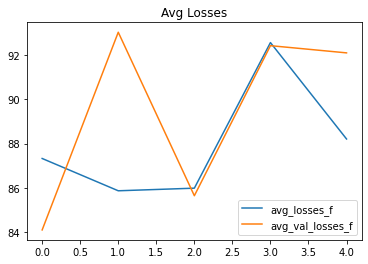

In [38]:
fig, ax = plt.subplots()
avg_losses_f_n=np.array(avg_losses_f)
avg_val_losses_f_n=np.array(avg_val_losses_f)
plt.plot(avg_losses_f_n, label='avg_losses_f')
plt.plot(avg_val_losses_f_n, label='avg_val_losses_f')
plt.title("Avg Losses")
plt.legend()

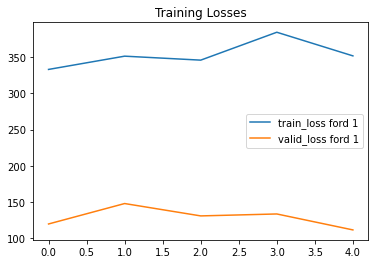

In [39]:
fig, ax = plt.subplots()
train_loss = np.array(train_loss)
valid_loss = np.array(valid_loss)
plt.plot(train_loss, label='train_loss ford 1')
plt.plot(valid_loss, label='valid_loss ford 1')
plt.title("Training Losses")
plt.legend()

In [41]:
def bestThresshold(y_train,train_preds):
    tmp = [0,0,0] # idx, cur, max
    delta = 0
    for tmp[0] in tqdm(np.arange(0.1, 0.501, 0.01)):
        tmp[1] = f1_score(y_train, np.array(train_preds)>tmp[0])
        if tmp[1] > tmp[2]:
            delta = tmp[0]
            tmp[2] = tmp[1]
    print('best threshold is {:.4f} with F1 score: {:.4f}'.format(delta, tmp[2]))
    return delta
delta = bestThresshold(y_train,train_preds)

  0%|          | 0/41 [00:00<?, ?it/s]

best threshold is 0.2500 with F1 score: 0.4115


In [42]:
y_train_test = y_train
train_preds
train_preds_test = (train_preds > delta).astype(int)

unique, counts = np.unique(train_preds_test, return_counts=True)
dict(zip(unique, counts))
# np.amax(train_preds_test)

{0: 9383, 1: 617}

# Evaluate

In [43]:
print(classification_report(y_train_test, train_preds_test))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      9363
           1       0.42      0.41      0.41       637

    accuracy                           0.93     10000
   macro avg       0.69      0.68      0.69     10000
weighted avg       0.93      0.93      0.93     10000

